In [2]:
%load_ext autoreload
%autoreload 2

import text3d2video.wandb_util as wu
from text3d2video.artifacts.vertex_atributes_artifact import VertAttributesArtifact

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
features_3d_artifact_tag = 'deadpool-3d-features:latest'

# get 3d features
features_3d = wu.get_artifact(features_3d_artifact_tag)
features_3d = VertAttributesArtifact.from_wandb_artifact(features_3d)
aggr_run = features_3d.logged_by()
mv_features = features_3d.get_mv_features_from_lineage()
animation = features_3d.get_animation_from_lineage()
vert_features = features_3d.get_vert_features().cuda()
log_timestep = aggr_run.config['feature_timestep']
level = aggr_run.config['feature_layer']
feature_identifier = {'layer': level, 'timestep': log_timestep}
feature_resolution = mv_features.get_resolution(feature_identifier)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact deadpool-mv-features:v4, 3446.13MB. 82 files... 
wandb:   82 of 82 files downloaded.  
Done. 0:0:1.0
wandb: Downloading large artifact deadpool-mv-features:v4, 3446.13MB. 82 files... 
wandb:   82 of 82 files downloaded.  
Done. 0:0:1.0
wandb: Downloading large artifact backflip:v0, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.3
/home/jorge/thesis/text3d2video/artifacts/vertex_atributes_artifact.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value fo

In [22]:
from einops import rearrange
from text3d2video.rendering import rasterize_vertex_features
from text3d2video.util import front_camera
from text3d2video.visualization import RgbPcaUtil
import matplotlib.pyplot as plt
import torch

frame_indices = [1, 2, 3]

camera = front_camera()

frames = animation.load_frames(frame_indices)

rendered_features = torch.stack([
    rasterize_vertex_features(camera, frame, feature_resolution, vert_features)
    for frame in frames
])

/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


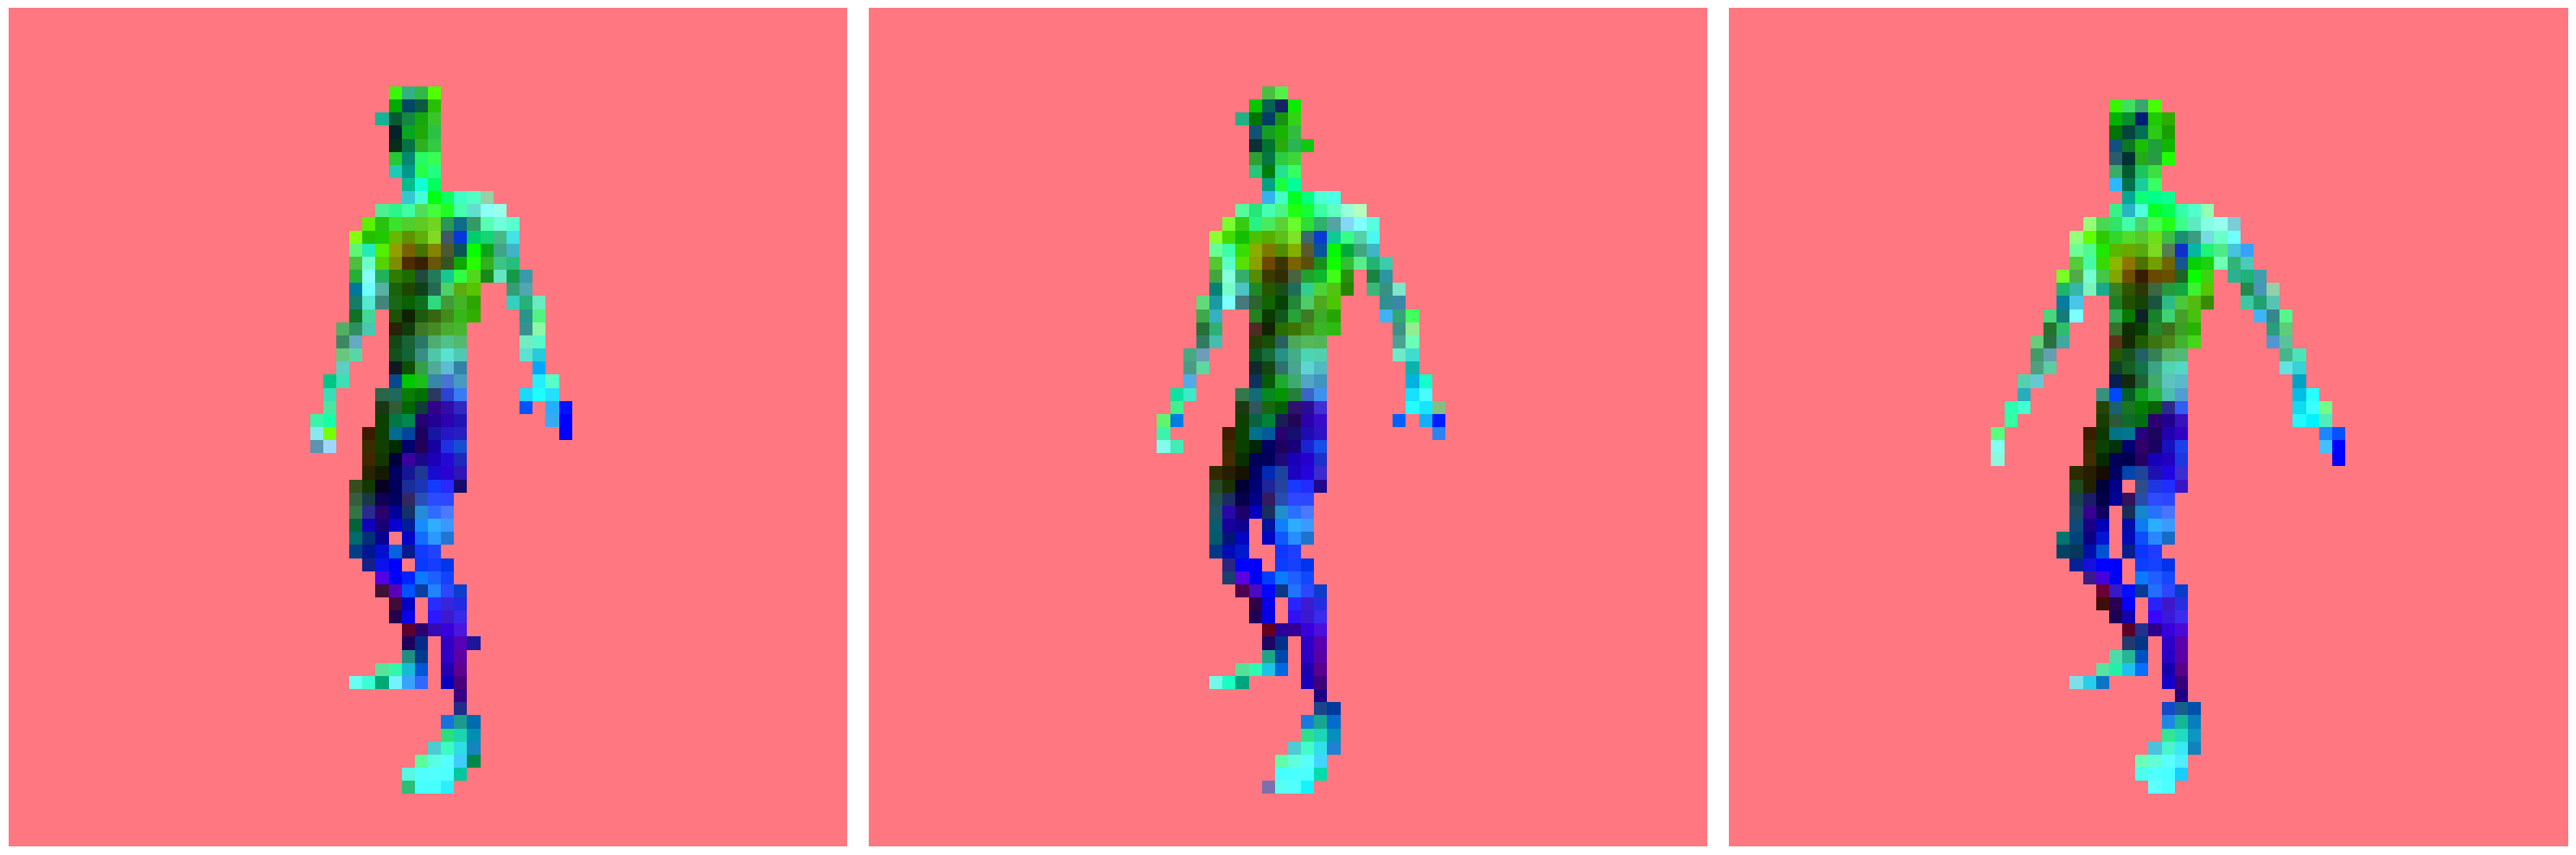

In [23]:
from text3d2video.ipython_utils import display_ims


all_features = rearrange(rendered_features, 'b c h w -> (b h w) c')
pca = RgbPcaUtil(all_features.shape[1])
pca.fit(all_features.cpu())
pca_maps = [pca.feature_map_to_rgb_pil(map.cpu()) for map in rendered_features]

display_ims(pca_maps, scale=10)

In [ ]:


feature_map = rendered_features[0]
features = rearrange(feature_map, "d h w -> (h w) d")
pca = RgbPcaUtil(features.shape[1])
pca.fit(features.cpu())
rendered_features_rgb = pca.feature_map_to_rgb(rendered_features.cpu())
plt.imshow(rendered_features_rgb.permute(1, 2, 0))